Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [5]:
#DAF understanding
print(filename)
#print(words[0:10])
print("len(count)=", len(count))
print("count: ", count[:10], "\n")
print("len(data)=", len(data))
print("data: ", data[:10] , "\n")
print("len(dictionary)=", len(dictionary))
print("dictionary: ", {k: dictionary[k] for k in dictionary.keys()[:10]}, "\n")
print("len(reverse_dictionary)=", len(reverse_dictionary))
print("reverse_dictionary: ", {k: reverse_dictionary[k] for k in reverse_dictionary.keys()[:10]}, "\n")

text8.zip
len(count)= 50000
count:  [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)] 

len(data)= 17005207
data:  [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] 

len(dictionary)= 50000
dictionary:  {'fawn': 45848, 'homomorphism': 9648, 'nordisk': 39343, 'nunnery': 36075, 'chthonic': 33554, 'sowell': 40562, 'showa': 32906, 'sonja': 38175, 'woods': 6263, 'hsv': 44222} 

len(reverse_dictionary)= 50000
reverse_dictionary:  {0: 'UNK', 1: 'the', 2: 'of', 3: 'and', 4: 'one', 5: 'in', 6: 'a', 7: 'to', 8: 'zero', 9: 'nine'} 



Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  #DAF understanding, comment lines later
  #batch = np.zeros(shape=(batch_size))
  #labels = np.zeros(shape=(batch_size, 1))
  


  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
    
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ] 
    #DAF: meaning of "targets_to_avoid": is to avoid *ALWAYS* that y^i(estimation from Xi(target)) equals Li (target)  
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      
      #DAF: the batch is filled with the element in the central position of the current buffer content
      batch[i * num_skips + j] = buffer[skip_window]
      #DAF: the labels are filled with another random element of the current buffer content
      labels[i * num_skips + j, 0] = buffer[target]
      #DAF: the target is label Li never equals y^i 
    
      #DAF understanding        
      #print("\nbatch_size=",batch_size," num_skips=",num_skips," skip_window=",skip_window)
      #print("buffer:", buffer, "Next data in buffer data[",data_index, "]=",data[data_index])
      #print("batch:", batch, "batch_index[",i * num_skips + j,"]=buffer[",skip_window,"]")
      #print("labels[",i * num_skips + j,",0]=buffer[target=",target, "] labels(T):", labels.reshape(8))
    
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]] , data[:8])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nSKIP-GRAM with num_skips = %d and skip_window = %d:' % (num_skips, skip_window), "\n")
    print('    batch:', batch)
    print('    batch.shape:', batch.shape)
    print('    batch (human readable):', [reverse_dictionary[bi] for bi in batch], "\n")
    print('    labels:',labels)
    print('    labels.shape:', labels.shape)
    print('    labels (human readable):', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('**********************************************************************************')

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'] [5239, 3084, 12, 6, 195, 2, 3137, 46]

SKIP-GRAM with num_skips = 2 and skip_window = 1: 

    batch: [3084 3084   12   12    6    6  195  195]
    batch.shape: (8,)
    batch (human readable): ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'] 

    labels: [[5239]
 [  12]
 [3084]
 [   6]
 [  12]
 [ 195]
 [   6]
 [   2]]
    labels.shape: (8, 1)
    labels (human readable): ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']
**********************************************************************************

SKIP-GRAM with num_skips = 4 and skip_window = 2: 

    batch: [12 12 12 12  6  6  6  6]
    batch.shape: (8,)
    batch (human readable): ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a'] 

    labels: [[5239]
 [ 195]
 [3084]
 [   6]
 [ 195]
 [3084]
 [  12]
 [   2]]
    labels.shape: (8, 1)
    labels (human readable): ['anarchism', 'term', 'originated', 'a', 'term', 'originated', '

Train a skip-gram model.

In [55]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

  valid_dataset = tf.constant(valid_examples, dtype=tf.int32) #tamaño del batch valid_dataset es valid_examples=16
  
  # Variables.
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))

  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  #DAF embed: 16 embeddings corresponding 16 datapoints of the current batch of the train_dataset, datapoint=index [0-49999]
  
  # Compute the softmax loss, using a sample of the negative labels each time.

  #DAF: Before we use loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # see video y https://stackoverflow.com/questions/35241251/in-tensorflow-what-is-the-difference-between-sampled-softmax-loss-and-softmax-c

  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))



  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # DAF: So far at this point (after the optimizer) we made the predictions
  # (train_prediction = tf.nn.softmax(logits); valid_prediction = tf.nn.softmax ; test_prediction = tf.nn.softmax)
  # That was the objective (to then calculate the accuracy of the models in train, validation and test sets)
  # Here the Objective is different: calculate the similarity (using cosine distance) 
  #  between the samples of the VALIDATION minibatch (shape = (16,128)) and all the normalized embeddings 
  # (shape=(50000,128)). Similarity es a Matmul (shape=(16,50000))


  # Compute the similarity between minibatch examples and all embeddings.
    
    
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #DAF: norm=sqrt(sum(embeddings^2))
    
  normalized_embeddings = embeddings / norm #DAF: normalized_embeddings are 50000

  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset) #DAF: valid_embeddings are 16
  
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  
  print("SKIP-GRAM::::")
  print("train_labels: ", train_labels, "\n")
  print("softmax_weights: ", softmax_weights)
  print("softmax_biases: ", softmax_biases, "\n")
  print("train_dataset: ", train_dataset)
  print("embed: ", embed)
  print("valid_dataset: ", valid_dataset, "\n")
  print("valid_embeddings: ", valid_embeddings)
  print("normalized_embeddings: ", normalized_embeddings)
  print("similarity: ", similarity)

SKIP-GRAM::::
train_labels:  Tensor("Placeholder_1:0", shape=(128, 1), dtype=int32, device=/device:CPU:0) 

softmax_weights:  <tf.Variable 'Variable_1:0' shape=(50000, 128) dtype=float32_ref>
softmax_biases:  <tf.Variable 'Variable_2:0' shape=(50000,) dtype=float32_ref> 

train_dataset:  Tensor("Placeholder:0", shape=(128,), dtype=int32, device=/device:CPU:0)
embed:  Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)
valid_dataset:  Tensor("Const:0", shape=(16,), dtype=int32, device=/device:CPU:0) 

valid_embeddings:  Tensor("embedding_lookup_1:0", shape=(16, 128), dtype=float32, device=/device:CPU:0)
normalized_embeddings:  Tensor("div:0", shape=(50000, 128), dtype=float32, device=/device:CPU:0)
similarity:  Tensor("MatMul:0", shape=(16, 50000), dtype=float32, device=/device:CPU:0)


In [82]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  
  average_loss = 0
  for step in range(num_steps):
        
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window) #DAF: generate_batch(128,1,2)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0

    if step % 10000 == 0:
      sim = similarity.eval() #DAF: this is an expensive operation (~20% slowdown if computed every 500 steps)
    
      for i in range(valid_size): #DAF valid_size=16
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1] #DAF: ...and maybe it could be expensive too

        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
            
        print(log)
        
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.237684
Nearest to when: nay, engaged, naboth, aelian, erin, pumice, mahmud, fetish,
Nearest to three: snowmobile, drones, portals, uplands, woven, inclusive, chatting, thurgood,
Nearest to used: zwickau, nozzles, csicop, matt, lengthy, solitude, aol, whit,
Nearest to were: escapement, colons, chewing, sane, ghost, ipsec, osamu, geralt,
Nearest to d: payne, luoyang, handguard, acquaintance, penicillin, chennai, cumann, uneconomic,
Nearest to see: judas, retardation, hypomania, dipping, puns, roast, diverted, eruption,
Nearest to on: tanya, rusty, irs, hk, shuttle, shootout, flatly, celled,
Nearest to in: freire, provides, bacall, programme, procopius, expeditions, scary, harbin,
Nearest to the: highness, peshawar, dover, lighten, constitutionalism, optimates, gandhara, wanderings,
Nearest to into: thunderstorm, pacifist, monocots, mondo, inks, engagements, hebrews, reasonable,
Nearest to from: trails, amnesty, mall, abendana, draconis, ranging, bact

In [83]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

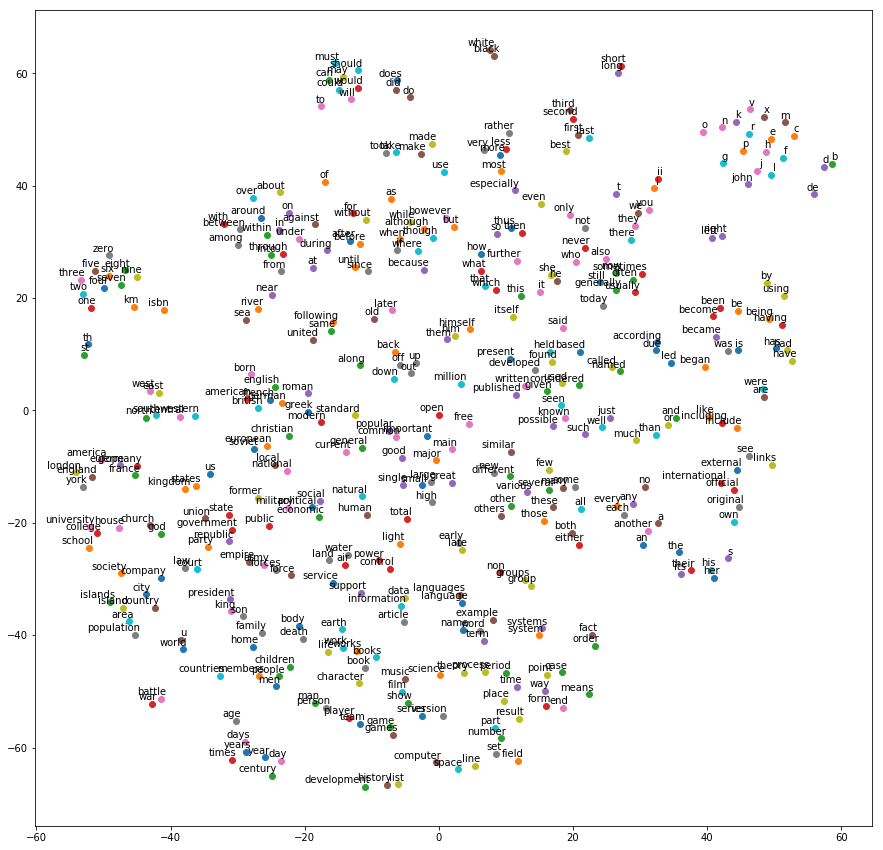

In [84]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [7]:
#DAF understanding
print(filename)
#print(words[0:10])
print("len(count)=", len(count))
print("count: ", count[:10], "\n")
print("len(data)=", len(data))
print("data: ", data[:10] , "\n")
print("len(dictionary)=", len(dictionary))
print("dictionary: ", {k: dictionary[k] for k in dictionary.keys()[:10]}, "\n")
print("len(reverse_dictionary)=", len(reverse_dictionary))
print("reverse_dictionary: ", {k: reverse_dictionary[k] for k in reverse_dictionary.keys()[:10]}, "\n")

text8.zip
len(count)= 50000
count:  [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)] 

len(data)= 17005207
data:  [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] 

len(dictionary)= 50000
dictionary:  {'fawn': 45848, 'homomorphism': 9648, 'nordisk': 39343, 'nunnery': 36075, 'chthonic': 33554, 'sowell': 40562, 'showa': 32906, 'sonja': 38175, 'woods': 6263, 'hsv': 44222} 

len(reverse_dictionary)= 50000
reverse_dictionary:  {0: 'UNK', 1: 'the', 2: 'of', 3: 'and', 4: 'one', 5: 'in', 6: 'a', 7: 'to', 8: 'zero', 9: 'nine'} 



In [9]:
data_index = 0

def generate_batch_cbow2(batch_size, skip_window):
  global data_index
  context_window = 2 * skip_window
  assert batch_size % context_window == 0
  num_labels = batch_size / context_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(num_labels):
    target = skip_window  # target label at the center of the buffer
    labels[i, 0] = buffer[target]
    targets_to_avoid = [ skip_window ]
    for j in range(context_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * context_window + j] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]] , data[:8])
for skip_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_cbow2(batch_size=8, skip_window=skip_window)
    print('\nCBOW with skip_window = %d:' % skip_window, "\n")
    print('    batch:', batch)
    print('    batch.shape:', batch.shape)
    #print('    batch(human readable):', [map(lambda bi: reverse_dictionary[bi], bi_lst) for bi_lst in batch])
    print('    labels:',labels)
    print('    labels.shape:', labels.shape)
    #print('    labels (human readable):', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('**********************************************************************************')

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'] [5239, 3084, 12, 6, 195, 2, 3137, 46]

CBOW with skip_window = 1: 

    batch: [  12 5239 3084    6  195   12    2    6]
    batch.shape: (8,)
    labels: [[3084]
 [  12]
 [   6]
 [ 195]]
    labels.shape: (4, 1)
**********************************************************************************

CBOW with skip_window = 2: 

    batch: [ 195    6 5239 3084   12  195 3084    2]
    batch.shape: (8,)
    labels: [[12]
 [ 6]]
    labels.shape: (2, 1)
**********************************************************************************


In [34]:
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

data_index = 0

def generate_batch_cbow(batch_size, skip_window):
    
  global data_index

  context_window = 2 * skip_window
  num_labels = batch_size / context_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
  
  #DAF understanding, comment this lines later
  #labels = np.zeros(shape=(batch_size))
  #batch = np.zeros(shape=(batch_size))

  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  res = list()
  for i in range(num_labels):
    buff_lst = list(buffer)          
    labels[i] = [buff_lst.pop(skip_window)]
    res.extend(buff_lst)
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  batch[0:] = res    
  return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]] , data[:8])
for skip_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, skip_window=skip_window)
    print('\nCBOW with skip_window = %d:' % skip_window, "\n")
    print('    batch:', batch)
    print('    batch.shape:', batch.shape)
    #print('    batch(human readable):', [map(lambda bi: reverse_dictionary[bi], bi_lst) for bi_lst in batch])
    print('    labels:',labels)
    print('    labels.shape:', labels.shape)
    #print('    labels (human readable):', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('**********************************************************************************')

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'] [5239, 3084, 12, 6, 195, 2, 3137, 46]

CBOW with skip_window = 1: 

    batch: [5239   12 3084    6   12  195    6    2]
    batch.shape: (8,)
    labels: [[3084]
 [  12]
 [   6]
 [ 195]]
    labels.shape: (4, 1)
**********************************************************************************

CBOW with skip_window = 2: 

    batch: [5239 3084    6  195 3084   12  195    2]
    batch.shape: (8,)
    labels: [[12]
 [ 6]]
    labels.shape: (2, 1)
**********************************************************************************


In [41]:
# DAF understanding: This is a way to test and paint variables and then incorporate them into the real code.

b = np.array([[i]*8 for i in range(10)])

graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

  batch = tf.constant(b)
  idxs = np.repeat(np.arange(5), 2)
  batch_reduced = tf.segment_sum(data=batch, segment_ids=idxs)
  
  skip_window = 1
  batch_size = 128
  segments = tf.constant([x / (2 * skip_window)  for x in range(batch_size)])

  #ts = tf.constant(batch)
  #embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  #embed = tf.nn.embedding_lookup(embeddings, ts)


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')

  print(batch.eval(), batch.get_shape(), "\n\n")
  print(batch_reduced.eval(), batch_reduced.get_shape(), "\n\n")
  print(segments.eval(), segments.get_shape(), "\n\n")

  #print(ts.eval())
  #print(embed.eval(), embed.get_shape())

Initialized
[[0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7]
 [8 8 8 8 8 8 8 8]
 [9 9 9 9 9 9 9 9]] (10, 8) 


[[ 1  1  1  1  1  1  1  1]
 [ 5  5  5  5  5  5  5  5]
 [ 9  9  9  9  9  9  9  9]
 [13 13 13 13 13 13 13 13]
 [17 17 17 17 17 17 17 17]] (?, 8) 


[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36 37
 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47 48 48 49 49
 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59 60 60 61 61 62
 62 63 63] (128,) 




In [35]:
#DAF understanding:
skip_window = 1 # How many words to consider left and right.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.random.randint(valid_window, size=(valid_size, skip_window*2))
print("valid_examples: ", valid_examples)
print("valid_examples.shape: ", valid_examples.shape)

embedding_size = 128
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
print("embeddings: ", embeddings) #50000 vector with len=128, values between -1 y 1 (cosine values)

valid_examples:  [[53 61]
 [32 90]
 [20 49]
 [99 62]
 [52 77]
 [44 73]
 [97 88]
 [53 27]
 [85 94]
 [57 58]
 [36  5]
 [95  3]
 [ 3 68]
 [80 53]
 [ 3 92]
 [51 76]]
valid_examples.shape:  (16, 2)
embeddings:  <tf.Variable 'Variable:0' shape=(50000, 128) dtype=float32_ref>


In [45]:
import sys 

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label. #DAF: HERE WE DONT USE THIS

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

context_window = 2 * skip_window
num_labels = batch_size / context_window

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  #train_dataset = tf.placeholder_with_default(tf.zeros([batch_size, 2 * skip_window]), 
                                              #shape=[batch_size, 2 * skip_window])

  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])

  train_labels = tf.placeholder(tf.int32, shape=[num_labels,1])

  valid_dataset = tf.constant(valid_examples, dtype=tf.int32) #tamaño del batch valid_dataset es valid_examples=16


  # Variables.
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) #shape(50000,128)

  softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))) #shape=(50000,128)

  softmax_biases = tf.Variable(tf.zeros([vocabulary_size])) #shape(50000,)
  
  # Model.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  segments = tf.constant([x / (2 * skip_window)  for x in range(batch_size)])
  embed_sum = tf.segment_sum(data=embed, segment_ids=segments)


  #DAF: BEFORE We use:
  #logits = tf.matmul(embed, softmax_weights) + softmax_biases
  #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_labels, logits=logits))


  # Compute the softmax loss, using a sample of the negative labels each time. #DAF: CBOW: NOT NEGATIVE LABELS
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_sum,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)) #num_sampled???

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)


  # Compute the similarity between minibatch examples and all embeddings.    
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm #shape=(50000, 128)

  #DAF: We use this Before and Now: valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset) #valid_embeddings son 16
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) #shape=(16, 50000)

  print("CBOW::::")
  print("train_labels: ", train_labels, "\n")
  print("softmax_weights: ", softmax_weights)
  print("softmax_biases: ", softmax_biases, "\n")
  print("train_dataset: ", train_dataset)
  print("embed: ", embed)
  print("valid_dataset: ", valid_dataset, "\n")
  print("valid_embeddings: ", valid_embeddings)
  print("normalized_embeddings: ", normalized_embeddings)
  print("similarity: ", similarity)

CBOW::::
train_labels:  Tensor("Placeholder_1:0", shape=(64, 1), dtype=int32, device=/device:CPU:0) 

softmax_weights:  <tf.Variable 'Variable_1:0' shape=(50000, 128) dtype=float32_ref>
softmax_biases:  <tf.Variable 'Variable_2:0' shape=(50000,) dtype=float32_ref> 

train_dataset:  Tensor("Placeholder:0", shape=(128,), dtype=int32, device=/device:CPU:0)
embed:  Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)
valid_dataset:  Tensor("Const:0", shape=(16,), dtype=int32, device=/device:CPU:0) 

valid_embeddings:  Tensor("embedding_lookup_1:0", shape=(16, 128), dtype=float32, device=/device:CPU:0)
normalized_embeddings:  Tensor("div:0", shape=(50000, 128), dtype=float32, device=/device:CPU:0)
similarity:  Tensor("MatMul:0", shape=(16, 50000), dtype=float32, device=/device:CPU:0)


In [46]:
num_steps = 100001
print("batch_size: ", batch_size)

with tf.Session(graph=graph) as session:
  print(session.run(tf.report_uninitialized_variables()))

  tf.global_variables_initializer().run()
  print('Initialized')
  
  average_loss = 0
  for step in range(num_steps):

    #batch_data, batch_labels = generate_batch_cbow(batch_size, skip_window) #batch_size=128, skip_window=1
    #print("batch_data: ", batch_data)
    batch_data, batch_labels = generate_batch_cbow(batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)

    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  final_embeddings = normalized_embeddings.eval()

batch_size:  128
['Variable' 'Variable_1' 'Variable_2' 'Variable/Adagrad'
 'Variable_1/Adagrad' 'Variable_2/Adagrad']
Initialized
Average loss at step 0: 8.432998
Nearest to time: morphology, contested, technically, kuiper, smooth, luis, mackaye, cutlery,
Nearest to its: slang, kidnappings, neq, saito, viv, bipm, malayan, iia,
Nearest to after: sibley, ossetia, straightforward, gte, fool, evolutionist, motorway, ruthless,
Nearest to many: partements, proverbial, rodney, flashback, grinch, customers, counterbalance, empowering,
Nearest to have: peers, irreducibly, gulfs, belles, oa, qb, reasonably, tooth,
Nearest to five: deoxygenated, bathed, opel, carey, preprint, puente, fay, arndt,
Nearest to if: homo, earned, ocampo, francophones, embraces, haldane, london, purposely,
Nearest to and: syllogisms, afternoon, sinhalese, enniskillen, feathers, kword, ri, haemoglobin,
Nearest to states: accede, evagrius, fred, gene, enormously, macroeconomic, brodsky, satisfies,
Nearest to would: drippi

In [47]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

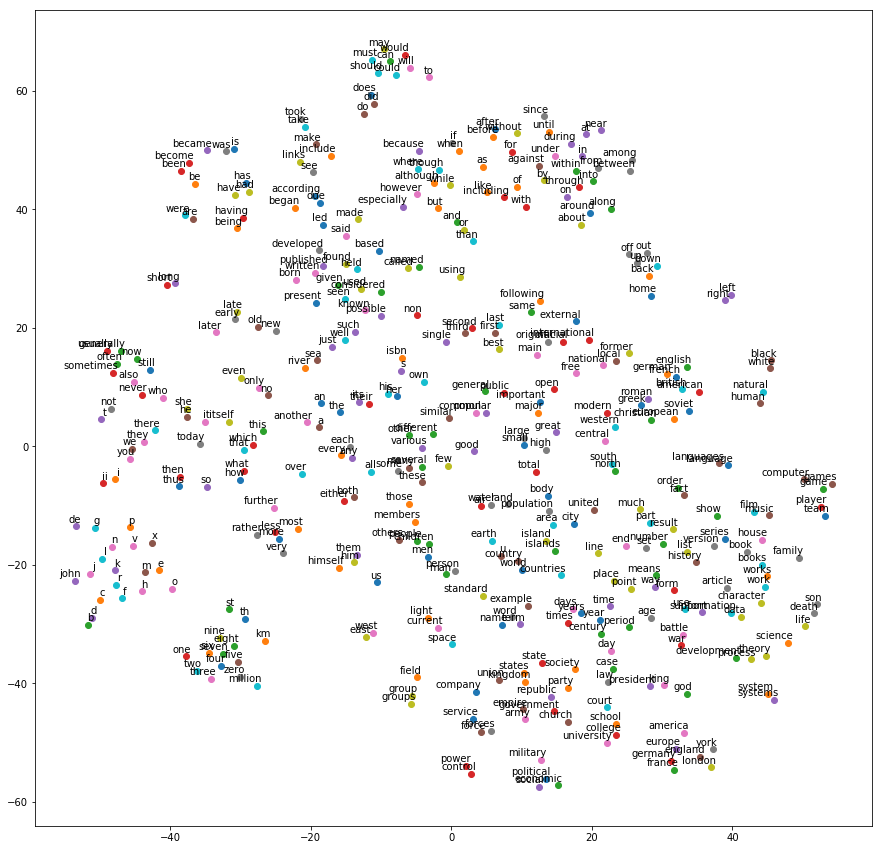

In [48]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)